# Sentiment Analysis - Labelled Financial News Data Using Transformer Models

In [115]:
# Importing the required libraries
import pandas as pd
import numpy as np
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer
from transformers import TrainingArguments
from transformers import Trainer
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification
import evaluate
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

### Loading the data

In [88]:
data = pd.read_csv('data/Fin_cleaned.csv', encoding='utf-8')

# duplicate the data
news = data.copy()

news

,Date_published,Headline,Synopsis,Full_text,Final Status
0,2022-06-21,"Banks holding on to subsidy share, say payment...",The companies have written to the National Pay...,ReutersPayments companies and banks are at log...,Negative
1,2022-04-19,Digitally ready Bank of Baroda aims to click o...,"At present, 50% of the bank's retail loans are...",AgenciesThe bank presently has 20 million acti...,Positive
2,2022-05-27,Karnataka attracted investment commitment of R...,Karnataka is at the forefront in attracting in...,PTIKarnataka Chief Minister Basavaraj Bommai.K...,Positive
3,2022-04-06,Splitting of provident fund accounts may be de...,The EPFO is likely to split accounts only at t...,Getty ImagesThe budget for FY22 had imposed in...,Negative
4,2022-06-14,Irdai weighs proposal to privatise Insurance I...,"Set up in 2009 as an advisory body, IIB collec...",AgenciesThere is a view in the insurance indus...,Positive
...,...,...,...,...,...
395,2022-06-10,"Banks take a cue from RBI, hike lending rates",These banks raised their respective external b...,"PTIICICI Bank, Bank of Baroda, Punjab National...",Negative
396,2022-06-29,Sebi issues Rs 27 lakh recovery notice to indi...,"In the event of non-payment, it will recover t...",ReutersThe logo of the Securities and Exchange...,Negative
397,2022-06-06,Apollo Hospital shares drop 0.68% as Sensex ...,"A total of 10,105 shares changed hands on the ...",Getty ImagesShrikant Chouhan of Kotak Securiti...,Negative
398,2022-05-16,SBI at Rs 710? What makes analysts see up to 5...,Calling the stock 'attractively valued' analys...,AgenciesThe PSU bank reported a 41.27 per cent...,Positive


### Data Preprocessing

In [89]:
# Fill the missing value with an empty string
news['Synopsis'] = news['Synopsis'].fillna('')

# Rename columns
news = news.rename(
    columns={'Date_published': 'date', 'Headline': 'headline', 'Synopsis': 'synopsis', 'Full_text': 'text',
             'Final Status': 'label'})

# Remove the spaces from the labels
news['label'] = news['label'].str.strip()

# Combine the headline, synopsis, and text columns
news['combined_text'] = news['headline'] + ' ' + news['synopsis'] + ' ' + news['text']

# Convert labels to binary
news['label'] = news['label'].apply(lambda x: 1 if x == 'Positive' else 0)

news

,date,headline,synopsis,text,label,combined_text
0,2022-06-21,"Banks holding on to subsidy share, say payment...",The companies have written to the National Pay...,ReutersPayments companies and banks are at log...,0,"Banks holding on to subsidy share, say payment..."
1,2022-04-19,Digitally ready Bank of Baroda aims to click o...,"At present, 50% of the bank's retail loans are...",AgenciesThe bank presently has 20 million acti...,1,Digitally ready Bank of Baroda aims to click o...
2,2022-05-27,Karnataka attracted investment commitment of R...,Karnataka is at the forefront in attracting in...,PTIKarnataka Chief Minister Basavaraj Bommai.K...,1,Karnataka attracted investment commitment of R...
3,2022-04-06,Splitting of provident fund accounts may be de...,The EPFO is likely to split accounts only at t...,Getty ImagesThe budget for FY22 had imposed in...,0,Splitting of provident fund accounts may be de...
4,2022-06-14,Irdai weighs proposal to privatise Insurance I...,"Set up in 2009 as an advisory body, IIB collec...",AgenciesThere is a view in the insurance indus...,1,Irdai weighs proposal to privatise Insurance I...
...,...,...,...,...,...,...
395,2022-06-10,"Banks take a cue from RBI, hike lending rates",These banks raised their respective external b...,"PTIICICI Bank, Bank of Baroda, Punjab National...",0,"Banks take a cue from RBI, hike lending rates ..."
396,2022-06-29,Sebi issues Rs 27 lakh recovery notice to indi...,"In the event of non-payment, it will recover t...",ReutersThe logo of the Securities and Exchange...,0,Sebi issues Rs 27 lakh recovery notice to indi...
397,2022-06-06,Apollo Hospital shares drop 0.68% as Sensex ...,"A total of 10,105 shares changed hands on the ...",Getty ImagesShrikant Chouhan of Kotak Securiti...,0,Apollo Hospital shares drop 0.68% as Sensex ...
398,2022-05-16,SBI at Rs 710? What makes analysts see up to 5...,Calling the stock 'attractively valued' analys...,AgenciesThe PSU bank reported a 41.27 per cent...,1,SBI at Rs 710? What makes analysts see up to 5...


## Create a dataset dictionary

In [90]:
# Create a dataset dictionary
dataset = Dataset.from_pandas(news[["combined_text", 'label']])

# Display the dataset dictionary    
dataset

Dataset({
    features: ['combined_text', 'label'],
    num_rows: 400
})

## Split the dataset into training and testing sets

In [91]:
# We will split the dataset into 80% training and 20% testing
train_test = dataset.train_test_split(test_size=0.2, seed=42)

In [92]:
# Now we will split the test set into 50% validation and 50% test
valid_test = train_test['test'].train_test_split(test_size=0.5, seed=42)

## Create a final dataset dictionary

In [93]:
# Combine the training, validation, and testing sets into a single dictionary
final_dataset = DatasetDict({
    'train': train_test['train'],
    'validation': valid_test['train'],
    'test': valid_test['test']
})

final_dataset

DatasetDict({
    train: Dataset({
        features: ['combined_text', 'label'],
        num_rows: 320
    })
    validation: Dataset({
        features: ['combined_text', 'label'],
        num_rows: 40
    })
    test: Dataset({
        features: ['combined_text', 'label'],
        num_rows: 40
    })
})

## Defining models

1. [Fine-tuned DistilRoBERTa for Financial News Sentiment Analysis](https://huggingface.co/mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis)

    This model is a distilled version of the RoBERTa-base model. It follows the same training procedure as DistilBERT. The model has 6 layers, 768 dimension and 12 heads, totalizing 82M parameters (compared to 125M parameters for RoBERTa-base). On average DistilRoBERTa is twice as fast as Roberta-base.
2. [DistilBERTa](https://huggingface.co/distilbert/distilbert-base-uncased)

    DistilBERTa is a transformers model, smaller and faster than BERT, which was pretrained on the same corpus in a self-supervised fashion, using the BERT base model as a teacher. This means it was pretrained on the raw texts only, with no humans labelling them in any way (which is why it can use lots of publicly available data) with an automatic process to generate inputs and labels from those texts using the BERT base model.

3. [FinBERT](https://huggingface.co/ProsusAI/finbert)

    FinBERT is a pre-trained NLP model to analyze sentiment of financial text. It is built by further training the BERT language model in the finance domain, using a large financial corpus and thereby fine-tuning it for financial sentiment classification.

In [96]:
# Models names
model_names = [
    "mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis",
    "distilbert-base-uncased",
    "ProsusAI/finbert"
]

# Hugging Face organization name for the models saving
huggingface_owner = "NLP-FEUP/"

# Create a models dictionary
models = {
    model: {
        'ft_saving_dir': huggingface_owner + "FT-" + model.replace("/", "-"),
        'tokenizer': AutoTokenizer.from_pretrained(model),
        'ft_dataset': DatasetDict({
            'train': train_test['train'],
            'validation': valid_test['train'],
            'test': valid_test['test']
        }),  # Dataset for Fine-tuning
    }
    for model in model_names
}


## Tokenization of the dataset

In [97]:
# Function to tokenize the dataset
def ft_tokenize_function(model, examples):
    return model['tokenizer'](examples['combined_text'], truncation=True, padding='max_length')


# Tokenize the dataset
for model in model_names:
    models[model]['ft_dataset'] = models[model]['ft_dataset'].map(
        lambda examples: ft_tokenize_function(models[model], examples),
        batched=True)

models[model_names[0]]['ft_dataset']

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['combined_text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 320
    })
    validation: Dataset({
        features: ['combined_text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 40
    })
    test: Dataset({
        features: ['combined_text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 40
    })
})

## Loading models

In [98]:
# Load the metric
metric = evaluate.load("accuracy")


# Define the function to compute the metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)


# Load all models
for model in model_names:
    # Load the model for fine-tuning
    models[model]['ft_model'] = AutoModelForSequenceClassification.from_pretrained(
        model, num_labels=2, ignore_mismatched_sizes=True
    )

    # Define the training arguments
    models[model]['ft_training_args'] = TrainingArguments(
        output_dir="./ft_training_results/" + model.replace("/", "-"),
        learning_rate=2e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=3,
        weight_decay=0.01,
        eval_strategy='epoch',
        save_strategy='epoch',
        load_best_model_at_end=True,
        push_to_hub=True,
        hub_model_id=models[model]['ft_saving_dir'],
    )

    # Define the data collator
    models[model]['ft_data_collator'] = DataCollatorWithPadding(tokenizer=models[model]['tokenizer'])

    # Define the trainer
    models[model]['ft_trainer'] = Trainer(
        model=models[model]['ft_model'],
        args=models[model]['ft_training_args'],
        train_dataset=models[model]['ft_dataset']['train'],
        eval_dataset=models[model]['ft_dataset']['validation'],
        data_collator=models[model]['ft_data_collator'],
        compute_metrics=compute_metrics,
        tokenizer=models[model]['tokenizer']
    )

config.json:   0%|          | 0.00/933 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Fine-tuning the models

In [27]:
# Train the model
ft_train = True
if ft_train:
    for model in model_names:
        print(f"Training {model}...")
        models[model]['ft_trainer'].train()

Training mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis...


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.198142,0.925000
2,No log,0.237997,0.925000
3,No log,0.330608,0.900000


Training distilbert-base-uncased...


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.681962,0.575000
2,No log,0.635410,0.725000
3,No log,0.595720,0.700000


Training ProsusAI/finbert...


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.397955,0.825000
2,No log,0.436315,0.875000
3,No log,0.391965,0.850000


In [28]:
# Evaluate the model
if ft_train:
    for model in model_names:
        print(f"Evaluating {model}...")
        models[model]['ft_trainer'].evaluate()

Evaluating mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis...


Evaluating distilbert-base-uncased...


Evaluating ProsusAI/finbert...


In [29]:
# Save the model to the hub
if ft_train:
    for model in model_names:
        print(f"Pushing {model} to Hugging Face...")
        models[model]['ft_trainer'].push_to_hub()

Pushing mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis to Hugging Face...
Pushing distilbert-base-uncased to Hugging Face...
Pushing ProsusAI/finbert to Hugging Face...


## Loading trained models

In [100]:
for model in model_names:
    # Load the tokenizer for the fine-tuned model
    models[model]['tokenizer_loaded'] = AutoTokenizer.from_pretrained(models[model]['ft_saving_dir'])

    # Load the model
    models[model]['ft_model_loaded'] = AutoModelForSequenceClassification.from_pretrained(
        models[model]['ft_saving_dir'],
        num_labels=2)
    # Define the trainer
    models[model]['ft_trainer_loaded'] = Trainer(
        model=models[model]['ft_model_loaded'],
        tokenizer=models[model]['tokenizer_loaded'],
        compute_metrics=compute_metrics,
    )

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

## Evaluate the model

In [101]:
# Predict the test set
for model in model_names:
    print(f"Predicting {model}...")
    models[model]['ft_predictions'] = models[model]['ft_trainer_loaded'].predict(models[model]['ft_dataset']['test'])

Predicting mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis...


Predicting distilbert-base-uncased...


Predicting ProsusAI/finbert...


In [102]:
# Display the predictions
models[model_names[0]]['ft_predictions']

PredictionOutput(predictions=array([[-1.0612382 ,  1.5146047 ],
       [ 1.575191  , -1.8632282 ],
       [-1.0152328 ,  1.5673753 ],
       [-0.85307145,  1.3295594 ],
       [ 1.4402982 , -1.6953844 ],
       [ 1.5586556 , -1.8569938 ],
       [-1.3161249 ,  1.8476328 ],
       [ 1.5201246 , -1.8928953 ],
       [ 1.4187825 , -1.6084824 ],
       [ 1.5430518 , -1.8358659 ],
       [-1.3577205 ,  1.8995434 ],
       [ 1.4820267 , -1.8462063 ],
       [ 1.5272502 , -1.9022475 ],
       [-1.2950958 ,  1.8081238 ],
       [-0.77065444,  1.326239  ],
       [ 1.5616184 , -1.8905199 ],
       [ 0.920575  , -0.94779855],
       [-1.3700954 ,  1.9410344 ],
       [ 1.5607334 , -1.7942139 ],
       [ 1.560798  , -1.8969575 ],
       [ 0.35795453, -0.10159986],
       [ 1.533297  , -1.8700018 ],
       [ 1.5325478 , -1.8366865 ],
       [ 1.535094  , -1.8930444 ],
       [ 1.5863767 , -1.886815  ],
       [-1.2188569 ,  1.7556137 ],
       [-1.3520945 ,  1.869646  ],
       [-1.1023163 ,  1.77

## Compute relevant metrics

In [103]:
# Initialize a dictionary to store the results
results_ft = {}

# Iterate over the model names
for model in model_names:
    # Get the predicted labels
    predicted_labels = np.argmax(models[model]['ft_predictions'].predictions, axis=-1)

    # Get the true labels
    true_labels = models[model]['ft_predictions'].label_ids

    # Compute the confusion matrix
    confusion = confusion_matrix(true_labels, predicted_labels)

    # Compute the accuracy
    accuracy = accuracy_score(true_labels, predicted_labels)

    # Compute the precision
    precision = precision_score(true_labels, predicted_labels)

    # Compute the recall
    recall = recall_score(true_labels, predicted_labels)

    # Compute the F1 score
    f1 = f1_score(true_labels, predicted_labels)

    # Store the results in the dictionary
    results_ft[model] = {
        'confusion_matrix': confusion,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

In [104]:
# Save the results to a dataframe
results_transformers = []
for model, metrics in results_ft.items():
    results_transformers.append({
        'Model': model,
        'Feature Representation': 'N/A',
        'Columns': 'combined_text',
        'F1-score': metrics['f1_score'],
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
    })

# Create a dataframe from the results
results_transformers_ft = pd.DataFrame(results_transformers)

results_transformers_ft.sort_values(by='F1-score', ascending=False)

,Model,Feature Representation,Columns,F1-score,Accuracy,Precision,Recall
0,mrm8488/distilroberta-finetuned-financial-news...,N/A,combined_text,0.937500,0.95,0.9375,0.9375
2,ProsusAI/finbert,N/A,combined_text,0.937500,0.95,0.9375,0.9375
1,distilbert-base-uncased,N/A,combined_text,0.777778,0.80,0.7000,0.8750


## Plot an F1-score comparison bar chart

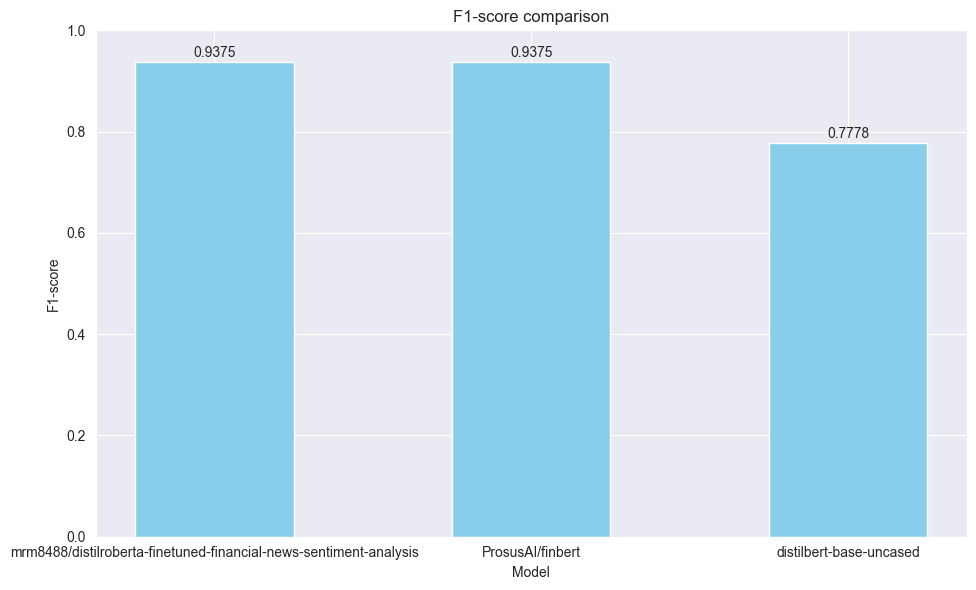

In [105]:
import matplotlib.pyplot as plt

data = results_transformers_ft.sort_values(by='F1-score', ascending=False)

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(data['Model'], data['F1-score'], color='skyblue', width=0.5)
plt.xlabel('Model')
plt.ylabel('F1-score')
plt.title('F1-score comparison')
plt.ylim(0, 1)
plt.tight_layout()
# Show values on the bars
for i, value in enumerate(data['F1-score']):
    plt.text(i, value + 0.01, f'{value:.4f}', ha='center')
plt.show()



## Plot the confusion matrix for the best model

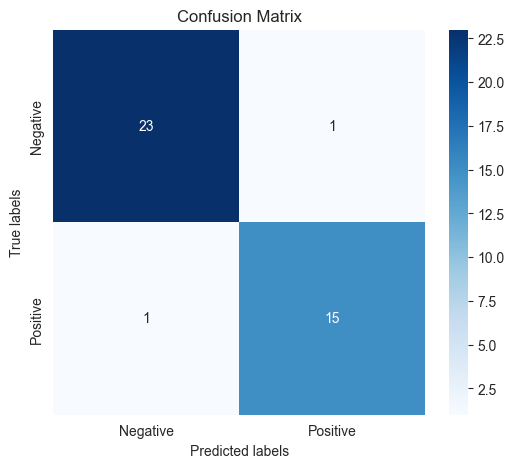

In [106]:
# Plot the confusion matrix
import seaborn as sns

# Define the labels
labels = ['Negative', 'Positive']

# Get the name of the model with the highest F1-score in results_transformers_ft
best_model = results_transformers_ft.loc[results_transformers_ft['F1-score'].idxmax()]['Model']

# Get the confusion matrix for the best model
confusion_matrix = results_ft[best_model]['confusion_matrix']

# Create the confusion matrix plot
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## Load results from previous assignment

In [107]:
# Load the results from the previous assignment to a list of dictionaries
previous_results = pd.read_csv('results/assignment1_comparison.csv')

# Display the previous results
previous_results

,Model,Columns,Feature Representation,F1-score,Accuracy,Precision,Recall
0,VADER,combined_text,NaN,0.723549,0.595,0.572973,0.981481
1,Multi-Layer Perceptron,"headline_embeddings, synopsis_embeddings",Word2Vec FinText AI,0.751323,0.755,0.758598,0.751341
2,Loughran-McDonald,combined_text,NaN,0.734545,0.635,0.604790,0.935185


In [108]:
# Concatenate the results
results = pd.concat([previous_results.copy(), results_transformers_ft], ignore_index=True)

# Save the results to a CSV file
results.to_csv('results/assignment2_comparison.csv', index=False)

# Sort the results by f1-score
results = results.sort_values(by='F1-score', ascending=False)

results

,Model,Columns,Feature Representation,F1-score,Accuracy,Precision,Recall
3,mrm8488/distilroberta-finetuned-financial-news...,combined_text,N/A,0.937500,0.950,0.937500,0.937500
5,ProsusAI/finbert,combined_text,N/A,0.937500,0.950,0.937500,0.937500
4,distilbert-base-uncased,combined_text,N/A,0.777778,0.800,0.700000,0.875000
1,Multi-Layer Perceptron,"headline_embeddings, synopsis_embeddings",Word2Vec FinText AI,0.751323,0.755,0.758598,0.751341
2,Loughran-McDonald,combined_text,NaN,0.734545,0.635,0.604790,0.935185
0,VADER,combined_text,NaN,0.723549,0.595,0.572973,0.981481


## Fine-tuning after domain adaptation

### Tokenization of the dataset

In [109]:
# Tokenization function for domain adaptation dataset
def da_tokenize_function(model, examples):
    return model['da_ft_tokenizer'](examples["combined_text"], truncation=True, padding='max_length')


for model in model_names:
    # Define the saving directory of the domain adaptation model
    models[model]['da_saving_dir'] = huggingface_owner + "DA-" + model.replace("/", "-")

    # Load the tokenizer
    models[model]['da_ft_tokenizer'] = AutoTokenizer.from_pretrained(models[model]['da_saving_dir'])

    # Create a dataset dictionary for fine-tuning after domain adaptation
    models[model]['da_ft_dataset'] = DatasetDict({
        'train': train_test['train'],
        'validation': valid_test['train'],
        'test': valid_test['test']
    })

    # Tokenize the dataset
    models[model]['da_ft_dataset'] = models[model]['da_ft_dataset'].map(
        lambda examples: da_tokenize_function(models[model], examples),
        batched=True
    )

tokenizer_config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

### Loading models for fine-tuning after domain adaptation

In [110]:
for model in model_names:
    # Define the saving directory
    models[model]['da_ft_saving_dir'] = huggingface_owner + "DA-FT-" + model.replace("/", "-")

    # Load the model
    models[model]['da_ft_model'] = AutoModelForSequenceClassification.from_pretrained(models[model]['da_saving_dir'],
                                                                                      num_labels=2)

    # Define the training arguments
    models[model]['da_ft_training_args'] = TrainingArguments(
        output_dir="./da_ft_training_results/" + model.replace("/", "-"),
        learning_rate=2e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=3,
        weight_decay=0.01,
        eval_strategy='epoch',
        save_strategy='epoch',
        load_best_model_at_end=True,
        push_to_hub=True,
        hub_model_id=models[model]['da_ft_saving_dir'],
    )

    # Define the data collator
    models[model]['da_ft_data_collator'] = DataCollatorWithPadding(tokenizer=models[model]['da_ft_tokenizer'])

    # Define the trainer
    models[model]['da_ft_trainer'] = Trainer(
        model=models[model]['da_ft_model'],
        args=models[model]['da_ft_training_args'],
        train_dataset=models[model]['da_ft_dataset']['train'],
        eval_dataset=models[model]['da_ft_dataset']['validation'],
        data_collator=models[model]['da_ft_data_collator'],
        compute_metrics=compute_metrics,
        tokenizer=models[model]['da_ft_tokenizer']
    )



config.json:   0%|          | 0.00/966 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at NLP-FEUP/DA-mrm8488-distilroberta-finetuned-financial-news-sentiment-analysis and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


config.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at NLP-FEUP/DA-distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


config.json:   0%|          | 0.00/821 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NLP-FEUP/DA-ProsusAI-finbert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Fine-tuning the models after domain adaptation

In [32]:
da_ft_train = True
if da_ft_train:
    # Train the models
    for model in model_names:
        print(f"Training {model}...")
        models[model]['da_ft_trainer'].train()

Training mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis...


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.322127,0.900000
2,No log,0.283001,0.875000
3,No log,0.301845,0.875000


Training distilbert-base-uncased...


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.676688,0.625000
2,No log,0.647639,0.675000
3,No log,0.620466,0.725000


Training ProsusAI/finbert...


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.524330,0.675000
2,No log,0.433225,0.775000
3,No log,0.376607,0.875000


### Evaluating the models after fine-tuning

In [33]:
if da_ft_train:
    # Evaluate the models
    for model in model_names:
        print(f"Evaluating {model}...")
        models[model]['da_ft_trainer'].evaluate()

Evaluating mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis...


Evaluating distilbert-base-uncased...


Evaluating ProsusAI/finbert...


### Saving the models to the hub after fine-tuning

In [34]:
if da_ft_train:
    # Save the models to the hub
    for model in model_names:
        print(f"Pushing {model} to Hugging Face...")
        models[model]['da_ft_trainer'].push_to_hub()

Pushing mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis to Hugging Face...
Pushing distilbert-base-uncased to Hugging Face...
Pushing ProsusAI/finbert to Hugging Face...


### Loading trained models after fine-tuning

In [111]:
for model in model_names:
    # Load the tokenizer
    models[model]['da_ft_tokenizer_loaded'] = AutoTokenizer.from_pretrained(models[model]['da_ft_saving_dir'])

    # Load the model
    models[model]['da_ft_model_loaded'] = AutoModelForSequenceClassification.from_pretrained(
        models[model]['da_ft_saving_dir'], num_labels=2)
    # Define the trainer
    models[model]['da_ft_trainer_loaded'] = Trainer(
        model=models[model]['da_ft_model_loaded'],
        tokenizer=models[model]['da_ft_tokenizer_loaded'],
        compute_metrics=compute_metrics,
    )

tokenizer_config.json:   0%|          | 0.00/1.41k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/834 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/738 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

### Predicting the test set

In [112]:
for model in model_names:
    # Predict the test set
    print(f"Predicting {model}...")
    models[model]['da_predictions'] = models[model]['da_ft_trainer_loaded'].predict(
        models[model]['da_ft_dataset']['test'])

Predicting mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis...


Predicting distilbert-base-uncased...


Predicting ProsusAI/finbert...


In [113]:
# Display the predictions
models[model_names[0]]['da_predictions']

PredictionOutput(predictions=array([[-1.4143077 ,  1.8865217 ],
       [ 1.5758506 , -1.7415456 ],
       [-1.2952677 ,  1.780877  ],
       [-1.2761613 ,  1.6741959 ],
       [-1.0812666 ,  1.4666804 ],
       [ 1.3374413 , -1.4681642 ],
       [-1.4673434 ,  1.9599478 ],
       [ 1.6264772 , -1.7845808 ],
       [-1.0004382 ,  1.3872668 ],
       [-0.65440357,  1.0551432 ],
       [-1.425289  ,  1.7941784 ],
       [ 1.1762983 , -1.1160709 ],
       [ 1.5977942 , -1.8039314 ],
       [-1.4831957 ,  1.8444029 ],
       [-1.2450815 ,  1.6688418 ],
       [ 1.6578315 , -1.8594109 ],
       [ 0.7709983 , -0.72900677],
       [-1.4354419 ,  1.7787657 ],
       [ 1.0136076 , -1.0861514 ],
       [ 1.715759  , -1.9160928 ],
       [ 0.17809583, -0.04435887],
       [ 1.6115366 , -1.803603  ],
       [-0.68443954,  0.9134275 ],
       [ 1.5628493 , -1.7143179 ],
       [ 1.7336373 , -1.8856356 ],
       [-1.2569096 ,  1.7686116 ],
       [-1.4757544 ,  1.9414469 ],
       [-1.4593319 ,  1.88

### Compute relevant metrics


In [116]:
# Initialize a dictionary to store the results
results_da = {}

# Iterate over the model names
for model in model_names:
    # Get the predicted labels
    predicted_labels = np.argmax(models[model]['da_predictions'].predictions, axis=-1)

    # Get the true labels
    true_labels = models[model]['da_predictions'].label_ids

    # Compute the confusion matrix
    confusion = confusion_matrix(true_labels, predicted_labels)

    # Compute the accuracy
    accuracy = accuracy_score(true_labels, predicted_labels)

    # Compute the precision
    precision = precision_score(true_labels, predicted_labels)

    # Compute the recall
    recall = recall_score(true_labels, predicted_labels)

    # Compute the F1 score
    f1 = f1_score(true_labels, predicted_labels)

    # Store the results in the dictionary
    results_da[model] = {
        'confusion_matrix': confusion,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

### Save the results to a dataframe

In [117]:
results_transformers_da = []
for model, metrics in results_da.items():
    results_transformers_da.append({
        'Model': "DA-" + model,
        'Feature Representation': 'N/A',
        'Columns': 'combined_text',
        'F1-score': metrics['f1_score'],
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
    })

# Create a dataframe from the results
results_da = pd.DataFrame(results_transformers_da)

results_da

,Model,Feature Representation,Columns,F1-score,Accuracy,Precision,Recall
0,DA-mrm8488/distilroberta-finetuned-financial-n...,N/A,combined_text,0.864865,0.875,0.761905,1.0000
1,DA-distilbert-base-uncased,N/A,combined_text,0.684211,0.700,0.590909,0.8125
2,DA-ProsusAI/finbert,N/A,combined_text,0.941176,0.950,0.888889,1.0000


### Plot an F1-score comparison bar chart

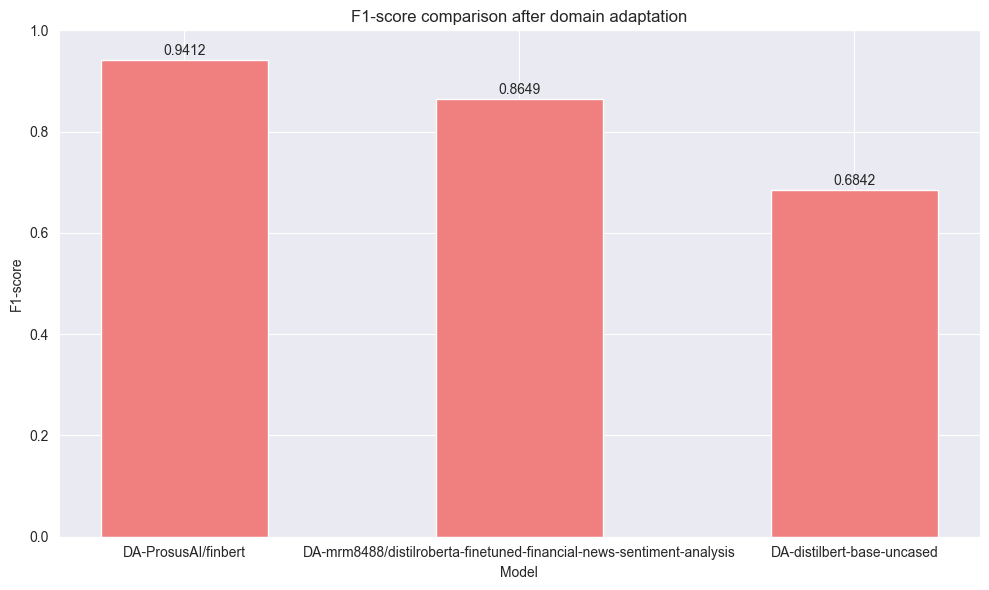

In [141]:
data = results_da.sort_values(by='F1-score', ascending=False)

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(data['Model'], data['F1-score'], color='lightcoral', width=0.5)
plt.xlabel('Model')
plt.ylabel('F1-score')
plt.title('F1-score comparison after domain adaptation')
plt.ylim(0, 1)
plt.tight_layout()
# Show values on the bars
for i, value in enumerate(data['F1-score']):
    plt.text(i, value + 0.01, f'{value:.4f}', ha='center')
    
plt.show()

### Compare with previous results

In [118]:
# Concatenate the results
results = pd.concat([results, results_da], ignore_index=True)

# Save the results to a CSV file
results.to_csv('results/assignment2_comparison_da.csv', index=False)

# Sort the results by f1-score
results = results.sort_values(by='F1-score', ascending=False)

results

,Model,Columns,Feature Representation,F1-score,Accuracy,Precision,Recall
8,DA-ProsusAI/finbert,combined_text,N/A,0.941176,0.950,0.888889,1.000000
0,mrm8488/distilroberta-finetuned-financial-news...,combined_text,N/A,0.937500,0.950,0.937500,0.937500
1,ProsusAI/finbert,combined_text,N/A,0.937500,0.950,0.937500,0.937500
6,DA-mrm8488/distilroberta-finetuned-financial-n...,combined_text,N/A,0.864865,0.875,0.761905,1.000000
2,distilbert-base-uncased,combined_text,N/A,0.777778,0.800,0.700000,0.875000
3,Multi-Layer Perceptron,"headline_embeddings, synopsis_embeddings",Word2Vec FinText AI,0.751323,0.755,0.758598,0.751341
4,Loughran-McDonald,combined_text,NaN,0.734545,0.635,0.604790,0.935185
5,VADER,combined_text,NaN,0.723549,0.595,0.572973,0.981481
7,DA-distilbert-base-uncased,combined_text,N/A,0.684211,0.700,0.590909,0.812500


### Plot a comparison bar chart

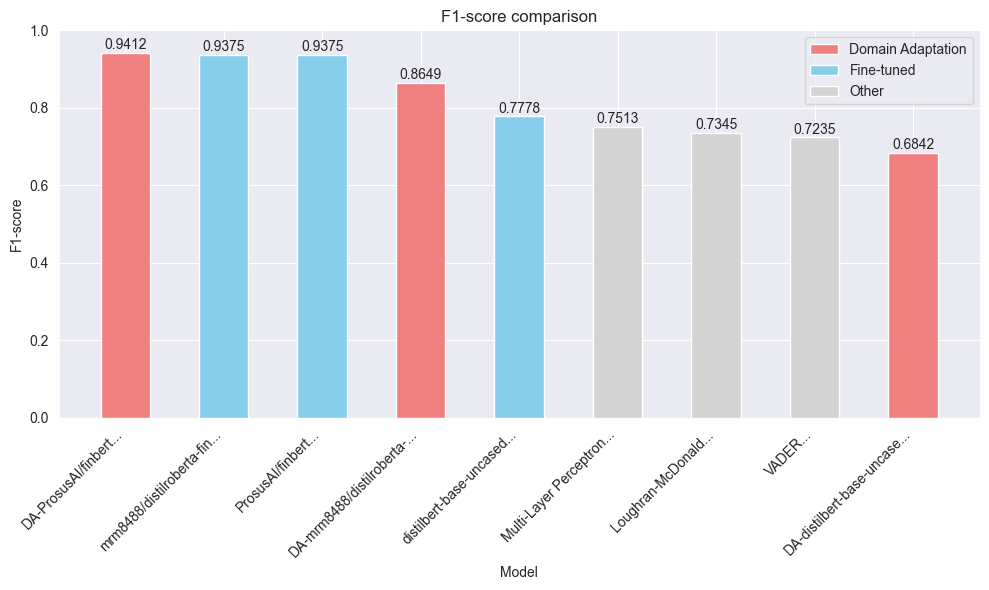

In [142]:
from matplotlib.patches import Patch

data = results.sort_values(by='F1-score', ascending=False)

# Define the colors
colors = []
for model in data['Model']:
    if model.startswith('DA-'):
        colors.append('lightcoral')
    elif model in model_names:
        colors.append('skyblue')
    else:
        colors.append('lightgray')

# Trim the model names to avoid overlap
data['Model'] = data['Model'].apply(lambda x: x[:25] + "...")

# Create a bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(data['Model'], data['F1-score'], color=colors, width=0.5)
plt.xlabel('Model')
plt.ylabel('F1-score')
plt.title('F1-score comparison')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.tight_layout()

# Create custom legend
legend_elements = [Patch(facecolor='lightcoral', label='Domain Adaptation'),
                   Patch(facecolor='skyblue', label='Fine-tuned'),
                   Patch(facecolor='lightgray', label='Other')]

plt.legend(handles=legend_elements, loc='upper right')

# Show values on the bars
for i, value in enumerate(data['F1-score']):
    plt.text(i, value + 0.01, f'{value:.4f}', ha='center')

plt.show()


The chart above demonstrates the F1-score comparison between all the models tested so far.

We can see a clear improvement with the introduction of transformers in this assignment comparing to the previous one. 

The best result was obtaining by the FinbertAI model after domain adaptation with an F1-score of 0.9412, which is remarkably higher than the best model from the previous assignment (Multi-Layer Perceptron).

Another score to notice if the performance of the distilbert model after domain adaptation, which achieved the lowest score from the other 8 models.